# MNIST classification with FCNN

In this practice, we will consider the problem of image classification with fully connected neural network.

We will solve the classic problem of handwritten digit recognition. The MNIST dataset has been created for this task. It contains images (28x28 pixels) of handwritten numbers from 0 to 9 -- i.e. There are 10 classes of pictures in total.

Afterwards we will see, how such a neural network works for the problem of image recognition in CIFAR datasets, which are a set of real images reduced to a size of 32x32 pixels.

# Seed random number generators

Random number generators generate different sets of random numbers from run to run by default. Since random numbers are used to initialize the network weights and to form the batches, the resulting neural network's weights will differ from run to run.

To make the results reproducible, it is necessary to initialize the random number generators with ```seed```s. This is done with the following commands: ```random.seed``` for the ```random``` library, ```np.random.seed``` for the ```numpy``` library. For pytorch, you will need several commands:

```
torch.manual_seed_all
torch.cuda.manual_seed_all
```

You will also need to switch ```cuda``` to deterministic mode:

```
torch.backends.cudnn.deterministic = True
```

In [26]:
import torch
import random
import numpy as np
import pandas as pd


In [2]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
random.seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True

# Load MNIST training and validation data into RAM

To do so, use the ```torchvision.datasets.MNIST``` class. Note that the training and test parts are controlled by the ```train``` parameter.

In [3]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor


In [4]:
MNIST_train = MNIST(root="./data", train=True, download=True, transform=ToTensor())
MNIST_test = MNIST(root="./data", train=False, download=True, transform=ToTensor())

# Check that everything works

In [5]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

print(X_train.shape, y_train.shape, '<- train dataset X and y')
print(X_test.shape, y_test.shape, '<- test dataset X and y')

print(X_train.dtype, y_train.dtype, '<- training data type')

torch.Size([60000, 28, 28]) torch.Size([60000]) <- train dataset X and y
torch.Size([10000, 28, 28]) torch.Size([10000]) <- test dataset X and y
torch.uint8 torch.int64 <- training data type


/opt/anaconda3/envs/conda-venv/lib/python3.10/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/opt/anaconda3/envs/conda-venv/lib/python3.10/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/opt/anaconda3/envs/conda-venv/lib/python3.10/site-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/opt/anaconda3/envs/conda-venv/lib/python3.10/site-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


# We give formats

PyTorch works with float tensors by default. Thus it is necessary to convert tensors with data to float using the tensor's ```.float()``` method. As a loss function, we will use ```torch.nn.CrossEntropy```, which takes as input the predictions of the neural network and the tensor from the numbers of the correct classes. This tensor must be in the ```long``` format. Since by default ```y``` in the dataset is already in the ```long``` format, there is no need to do anything with the labels.

In [6]:
X_train = X_train.float() / 255
X_test = X_test.float() / 255


# View the data

Visually evaluate the data that we have. Let's check that the markup matches what is contained in the picture. To do this, let's display an image with ```plt.imshow``` and see which label corresponds to this image.

Pay attention to this code: in the following tasks, you will need to make mappings yourself.

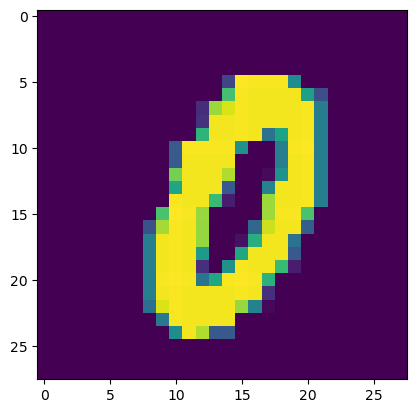

tensor(0)


In [7]:
import matplotlib.pyplot as plt

index = 34

plt.imshow(X_train[index, :, :])
plt.show()
print(y_train[index])

# Prepare the neural network

In order to make a neural network in Pytorch, one should prepare a class inherited from ```pytorch.nn.Module```, which has two functions:

* ```__init__(self, n_hidden_neurons)``` -- a constructor in which we define the modules that we use in the neural network. Before declaring modules, you need to initialize the parent class with ```super().__init__()```, after which you can declare the necessary modules
The neural network in our case will consist of only three modules. Schematically, a neural network can be represented as follows:
```
torch.nn.Linear 28*28 -> n_hidden_neurons
torch.nn.LeakyReLU
torch.nn.Linear n_hidden_heurons -> 10
```

* ```forward(self, x)``` -- traverse the network forward. Here it is necessary to get forecasts for ```x```. ```x``` is a batch of images converted to a vector. Batch is a tensor of size ```N x 784```, where ```N``` is the number of images in the batch, ```784``` is the number of pixels in the black and white image (```28 x 28```). Apply the ```reshape([-1, 784])``` method to the input ```x``` (```-1``` here means "the number that fits", it will be automatically derived from amount of elements in the batch). After that successively apply the modules declared in the constructor to the signal and return the result.

In [8]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super().__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.relu = torch.nn.LeakyReLU()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the image to a 1D vector
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


# Check that everything is correct

In [9]:
mnist_net = MNISTNet(100)
res = mnist_net(torch.zeros(10, 28*28))
assert res.shape[0] == 10
print(res.shape, '<- shape of predictions')

torch.Size([10, 10]) <- shape of predictions


# Set the loss function and optimizer

We will use ```torch.nn.CrossEntropyLoss``` as a loss function

We will use ```torch.nn.Adam``` as an optimizer

The optimizer should optimize all parameters of the neural network (which can be referenced using the ```mnist_net.parameters()``` method) and the learning rate should be set to $10^{-3}$.

In [10]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1e-3)

# Let's build the learning process

Everything is ready: optimizer, loss function, neural network. What remains is to train the neural network.

To do so, you need to create a learning cycle.

The training loop usually consists of two nested loops: the inner loop runs through all the examples in the training or testing set. One such pass is called an epoch.

The outer cycle iterates over epochs.

# Instructions for building a training loop

* Make an outer loop for a predetermined number of epochs within which:
   * Generate a random order of the training examples using the ```order = np.random.permutation(...)``` method
   * Make an inner loop through the training examples. The loop should iterate over ```order``` with interval ```batch_size``` (```range(0, len(order), batch_size)```), in which:
     * Get the indice of the training examples for the current step by slicing ```indice = order[start_index:start_index+batch_size]```.
     * Next, from the training examples and labels, you need to select the appropriate examples and labels using indexing (```X_batch = X[indice]```).
     * Now we are ready to get neural network predictions. If you are using batch normalization or DropOut, then here you need to switch the network to training mode (```net.train()```). It always is better to have.
     * Get predictions for the received batch using a neural network (```batch_preds = net.forward(X_batch)```).
     * Calculate the value of the loss function based on the predictions and batch labels
     * Reset the gradients accumulated in the neural network nodes to be optimized (```optimizer.zero_grad()```).
     * Calculate the gradients of the loss function from the parameters of the neural network ```loss.backward()```
     * Take an optimizer step (```optimizer.step()```).
     * If you are using batch normalization or DropOut, switch the neural network to validation mode (```net.valid()```). It always is better to have.

   * Calculate predictions for the test set (in our case, this can be done in one batch, ```test_preds = net(X_test)```)
   * Calculate the accuracy for the test set.
   * Calculate the loss function for the test set.
   * Add calculated accuracy to accuracy history and loss to loss history

In [20]:
batch_size = 100
n_epochs = 70

train_loss_history = []
train_accuracy_history = []

test_accuracy_history = []
test_loss_history = []

for epoch in range(n_epochs):
    mnist_net.train()
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        batch_indices = order[start_index:start_index + batch_size]
        X_batch = X_train[batch_indices]
        y_batch = y_train[batch_indices]

        optimizer.zero_grad()
        predictions = mnist_net(X_batch)
        loss_value = loss(predictions, y_batch)
        loss_value.backward()
        optimizer.step()
    
        train_loss_history.append(loss_value.item())
        train_accuracy_history.append(
            (predictions.argmax(dim=1) == y_batch).float().mean().item()
        )

    mnist_net.eval()
    with torch.no_grad():
        test_predictions = mnist_net(X_test)
        test_loss = loss(test_predictions, y_test).item()
        test_accuracy = (test_predictions.argmax(dim=1) == y_test).float().mean().item()
        
        test_loss_history.append(test_loss)
        test_accuracy_history.append(test_accuracy)

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss_history[-1]:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch 1/70, Train Loss: 0.1814, Test Loss: 0.1591, Test Accuracy: 0.9545
Epoch 2/70, Train Loss: 0.0893, Test Loss: 0.1248, Test Accuracy: 0.9656
Epoch 3/70, Train Loss: 0.1246, Test Loss: 0.1065, Test Accuracy: 0.9683
Epoch 4/70, Train Loss: 0.1337, Test Loss: 0.0944, Test Accuracy: 0.9716
Epoch 5/70, Train Loss: 0.0603, Test Loss: 0.0906, Test Accuracy: 0.9729
Epoch 6/70, Train Loss: 0.0377, Test Loss: 0.0839, Test Accuracy: 0.9744
Epoch 7/70, Train Loss: 0.0257, Test Loss: 0.0848, Test Accuracy: 0.9754
Epoch 8/70, Train Loss: 0.0245, Test Loss: 0.0746, Test Accuracy: 0.9785
Epoch 9/70, Train Loss: 0.0163, Test Loss: 0.0753, Test Accuracy: 0.9775
Epoch 10/70, Train Loss: 0.0304, Test Loss: 0.0763, Test Accuracy: 0.9767
Epoch 11/70, Train Loss: 0.0534, Test Loss: 0.0740, Test Accuracy: 0.9776
Epoch 12/70, Train Loss: 0.0192, Test Loss: 0.0786, Test Accuracy: 0.9774
Epoch 13/70, Train Loss: 0.0110, Test Loss: 0.0735, Test Accuracy: 0.9779
Epoch 14/70, Train Loss: 0.0063, Test Loss: 0.0

# Plot the learning progress graph

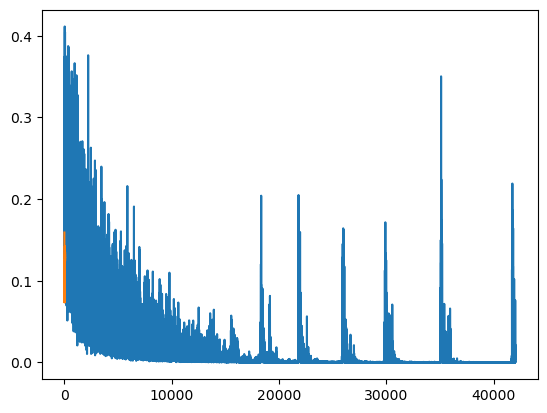

In [21]:
plt.plot(train_loss_history)
plt.plot(test_loss_history)

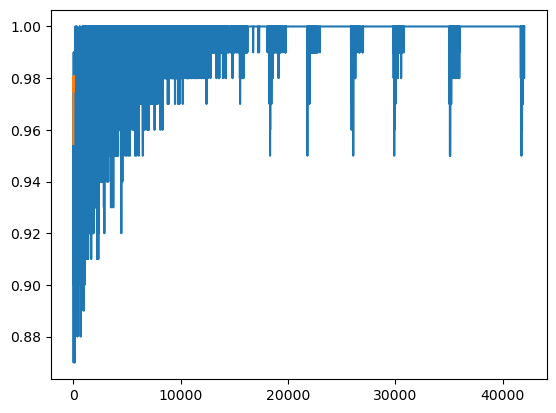

In [22]:
plt.plot(train_accuracy_history)
plt.plot(test_accuracy_history)

1.5.2


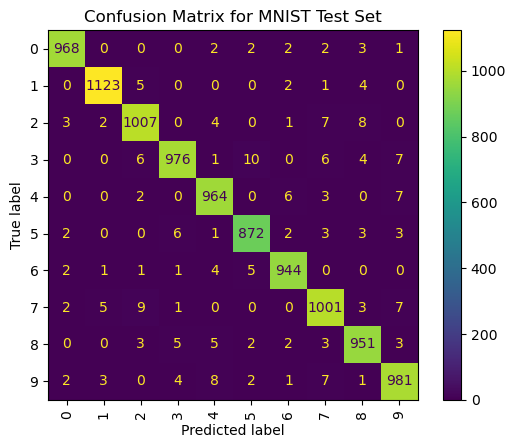

In [23]:
import sklearn
print(sklearn.__version__)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

mnist_net.eval()

# Get predictions for the test dataset
with torch.no_grad():
    test_predictions = mnist_net(X_test).argmax(dim=1).cpu().numpy()
    y_test_np = y_test.cpu().numpy()  # Convert ground truth to NumPy array

# Compute the confusion matrix
cm = confusion_matrix(y_test_np, test_predictions, labels=range(10))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap="viridis", xticks_rotation="vertical")

plt.title("Confusion Matrix for MNIST Test Set")
plt.show()


# Afterword

You have done your first cycle of learning on your own. It is quite simple and concise, takes no more than 100 lines, and it is quite easy to rewrite it. More and more functionality can be added to this learning cycle. As a result, the learning loop will become very large and unreadable, the logic inside the loop will be quite difficult to understand.

In order not to think about training cycles, libraries have been developed to simplify the training of neural networks, such as PyTorch Lightning. We'll get to know PyTorch Lightning in the next practice.

# Kaggle competition

In [27]:
train_data = pd.read_csv('/Users/giorgikurtanidze/Documents/GitHub/HW3-Neural-Networks/digit-recognizer/train.csv')
test_data = pd.read_csv('/Users/giorgikurtanidze/Documents/GitHub/HW3-Neural-Networks/digit-recognizer/test.csv')

In [33]:
X_train = train_data.iloc[:, 1:].values / 255.0  
y_train = train_data.iloc[:, 0].values          
X_test = test_data.values / 255.0     

X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

In [34]:
# Assuming your model and other necessary components (optimizer, loss) are defined
batch_size = 100
n_epochs = 30

train_loss_history = []
train_accuracy_history = []

for epoch in range(n_epochs):
    mnist_net.train()
    order = np.random.permutation(len(X_train))

    for start_index in range(0, len(X_train), batch_size):
        batch_indices = order[start_index:start_index + batch_size]
        X_batch = X_train[batch_indices]
        y_batch = y_train[batch_indices]

        # Convert X_batch to PyTorch tensor and flatten
        X_batch = torch.tensor(X_batch, dtype=torch.float32)  # Convert to tensor
        X_batch = X_batch.view(-1, 28 * 28)  # Flatten the input for the fully connected layer
        y_batch = torch.tensor(y_batch, dtype=torch.long)  # Convert y_batch to tensor for classification

        optimizer.zero_grad()
        predictions = mnist_net(X_batch)
        loss_value = loss(predictions, y_batch)
        loss_value.backward()
        optimizer.step()

        # Optionally, track loss and accuracy for training
        train_loss_history.append(loss_value.item())
        train_accuracy_history.append((predictions.argmax(dim=1) == y_batch).float().mean().item())

    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {np.mean(train_loss_history)}, Accuracy: {np.mean(train_accuracy_history)}")


Epoch 1/30, Loss: 4.223521827384502e-05, Accuracy: 1.0
Epoch 2/30, Loss: 4.015577402852056e-05, Accuracy: 1.0
Epoch 3/30, Loss: 3.812208603585802e-05, Accuracy: 1.0
Epoch 4/30, Loss: 3.629594655480432e-05, Accuracy: 1.0
Epoch 5/30, Loss: 3.461166229170333e-05, Accuracy: 1.0
Epoch 6/30, Loss: 3.300721800820996e-05, Accuracy: 1.0
Epoch 7/30, Loss: 3.150341290838027e-05, Accuracy: 1.0
Epoch 8/30, Loss: 3.014474925399873e-05, Accuracy: 1.0
Epoch 9/30, Loss: 2.8856386384990114e-05, Accuracy: 1.0
Epoch 10/30, Loss: 2.762843536167736e-05, Accuracy: 1.0
Epoch 11/30, Loss: 2.646401582550072e-05, Accuracy: 1.0
Epoch 12/30, Loss: 2.536425014231465e-05, Accuracy: 1.0
Epoch 13/30, Loss: 0.00010527741535934623, Accuracy: 0.9999816849991515
Epoch 14/30, Loss: 0.0009778646443452037, Accuracy: 0.9997278913855553
Epoch 15/30, Loss: 0.0009636002129763241, Accuracy: 0.9997253970588956
Epoch 16/30, Loss: 0.0009138691667432985, Accuracy: 0.9997410716488957
Epoch 17/30, Loss: 0.0008636057868161848, Accuracy:

In [36]:
import torch

X_test = torch.tensor(X_test, dtype=torch.float32)

X_test = X_test.view(-1, 28 * 28)

mnist_net.eval()

with torch.no_grad():
    test_predictions = mnist_net(X_test)
    predicted_labels = test_predictions.argmax(dim=1).numpy() 


In [37]:
submission = pd.DataFrame({
    "ImageId": list(range(1, len(predicted_labels) + 1)),
    "Label": predicted_labels
})

submission.to_csv('submission.csv', index=False)
